In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from load_data import get_data
from graphs import *

## Few notes:
* **total_clearance_between_visit** - wzgledem poprzedniej wizyty
* **clearance_between_visit** - wzgledem poczatku


#### To-dos:
* Sprawdz ilosc grup z peaku w gory!
* Sprawdzic linear fit i non-linear fit
* Sprawdz rozne 
* Sprawdz methodologie
* Sila statystyczna (p-value)
* Sprawdz rozne kwartaly
* Pogrobic linie

#### Few **old** notes:
* The table above should include all information You need
* `wizyta po ilu zabiegach` -> can have some skipped zabiegy & can start at other point than 0
* `czas` -> defined as czas between this and next visit

# Hard-Coded Area:

In [2]:
non_moved_df = get_data(format_type='all')
moved_df = get_data(format_type='moved_to_0')
non0s_df = get_data(format_type='all_without_0s')

print('looking at the moved data:')
moved_df.head(30)

default time group has GROUPS defined as: [0, 90, 180, 270, 360]
default time group has GROUPS defined as: [0, 90, 180, 270, 360]
default time group has GROUPS defined as: [0, 90, 180, 270, 360]
looking at the moved data:


,surname,time,summed_time,time_group,visit_number,total_clearance_between_visit,clearance_between_visit,------------,unmoved_visit_nr
0,1.Gasek,57,57,1,1,10.435940,10.435942,,1
1,1.Gasek,958,1015,4,2,14.814190,-1.710566,,2
2,1.Gasek,70,1085,1,3,10.424290,-2.877283,,3
3,1.Gasek,63,1148,1,4,24.239930,24.671780,,4
4,1.Gasek,238,1386,3,5,17.252580,-0.692089,,5
5,2. Kolodziejska,217,217,2,1,66.956580,66.956580,,1
6,2. Kolodziejska,42,259,0,2,41.810011,6.917547,,2
7,2. Kolodziejska,26,285,0,5,25.568145,-10.812106,,5
8,2. Kolodziejska,294,579,3,6,86.486312,22.210066,,6
9,4. Krzyszton,35,35,0,1,-46.287701,-17.363140,,3


# Main Graphs
### Srednia poprawa miedzy wizytami:

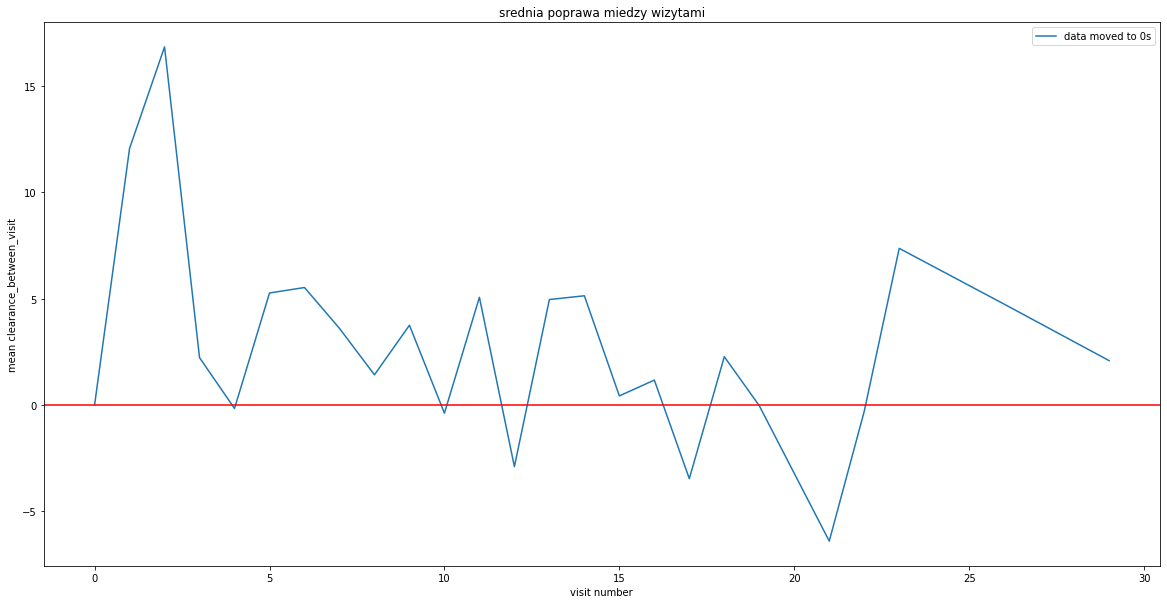

In [3]:
plt.figure(figsize=(20,10))
plt.title("srednia poprawa miedzy wizytami")
agg_column_graph(moved_df, label = 'data moved to 0s')
plt.legend()

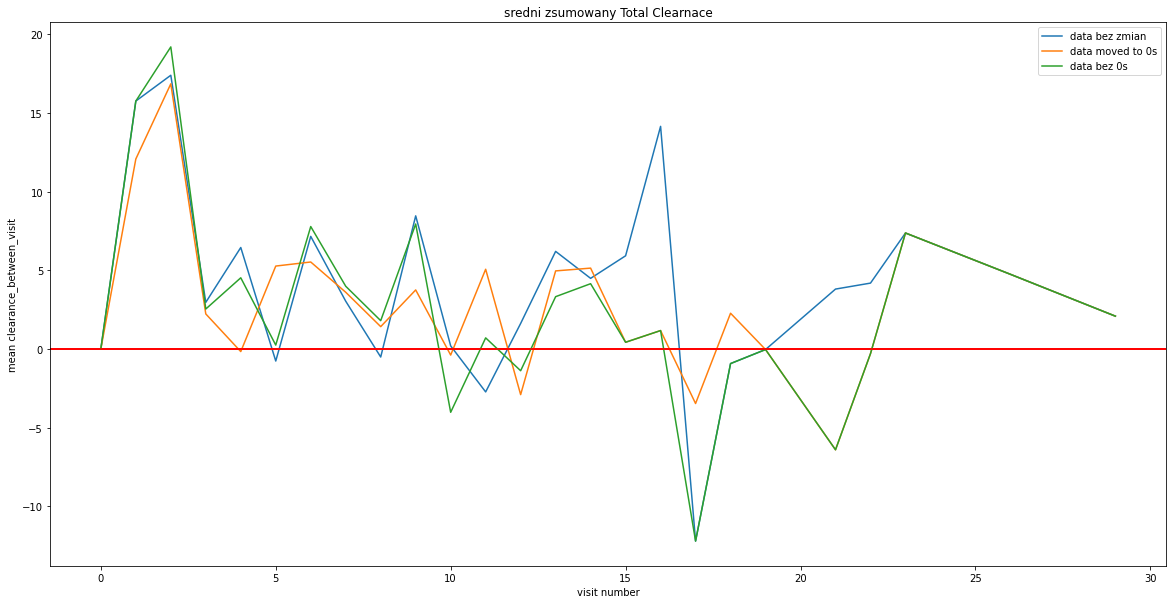

In [4]:
plt.figure(figsize=(20,10))
plt.title("sredni zsumowany Total Clearnace")
agg_column_graph(non_moved_df, label = 'data bez zmian')
agg_column_graph(moved_df, label = 'data moved to 0s')
agg_column_graph(non0s_df, label = 'data bez 0s')
plt.legend()

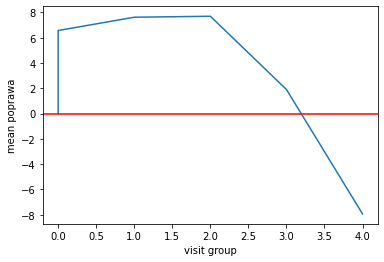

In [5]:
time_group_based_avg_graph(non_moved_df) 

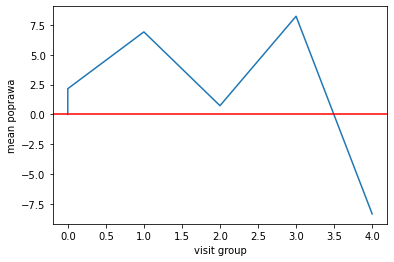

In [6]:
time_group_based_avg_graph(non_moved_df.loc[non_moved_df.visit_number > 5]) # Dla wizyt powyzej 5

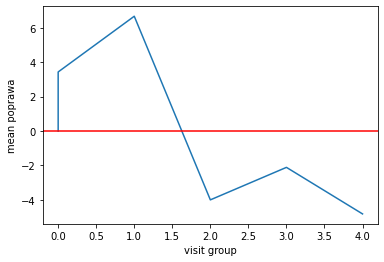

In [7]:
time_group_based_avg_graph(non_moved_df.loc[non_moved_df.visit_number > 10]) # Dla wizyt powyzej 10

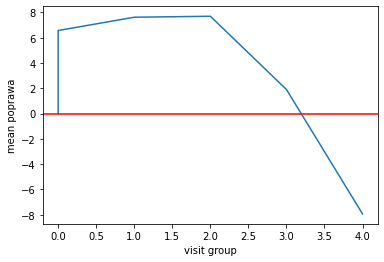

In [8]:
time_group_based_avg_graph(moved_df) # Dla wszystkich wizyt

### All users plots:

In [9]:
# plot_all_users(non_moved_df, title = 'data bez zmian')
# plot_all_users(moved_df, title = 'data moved to 0s')
# plot_all_users(non0s_df, title = 'data bez 0s')

# Exploratory area: